In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from torch.utils.data import DataLoader

from models.MeTooDataset import MeTooDataset

In [2]:
experiment_name = '12B'

In [3]:
stopwords_en = stopwords.words('english')
stopwords_en.extend(['quote', 'answer', 'retweet', 'full', 'text']) # Additional stopwords due to Twitter API and annotation process

In [4]:
tokenizer = TweetTokenizer()

In [5]:
targets = ['Objectification of Women', 'Gender Equality', 'Conservatism']

In [6]:
targets_mapper = {
    0: 'Objectification of Women',
    1: 'Gender Equality',
    2: 'Conservatism'
}

In [7]:
labels = ['Against', 'Neutral', 'Favor']

In [8]:
labels_mapper = {
    0: 'Against',
    1: 'Neutral',
    2: 'Favor'
}

In [9]:
profile_ids = [783214, 19568591, 25073877, 103018203, 256881576, 810619093749559296]

In [10]:
users = list('ABCDEF')

# Setup

In [11]:
dataset_obj = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='stance_training',
    target='Objectification of Women'
)

In [12]:
dataloader_obj = DataLoader(dataset_obj)

In [13]:
dataset_gen = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='stance_training',
    target='Gender Equality'
)

In [14]:
dataloader_gen = DataLoader(dataset_gen)

In [15]:
dataset_con = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='stance_training',
    target='Conservatism'
)

In [16]:
dataloader_con = DataLoader(dataset_con)

# Preparing Vocabularies

In [17]:
target_vocabularies = {
    'Objectification of Women':  {
        'Against': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_obj)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 0
        ),
        'Neutral': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_obj)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 1
        ),
        'Favor': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_obj)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 2
        )
    },
    'Gender Equality':  {
        'Against': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_gen)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 0
        ),
        'Neutral': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_gen)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 1
        ),
        'Favor': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_gen)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 2
        )
    },  
    'Conservatism':  {
        'Against': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_con)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 0
        ),
        'Neutral': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_con)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 1
        ),
        'Favor': set(
            word
            for _, (tweet, stance) in enumerate(dataloader_con)
            for word in tokenizer.tokenize(tweet[0])
            if stance == 2
        )
    },
}

# Computing Unique Vocabularies

In [18]:
unique_target_vocabularies = {
    target: {
        label: target_vocabularies[target][label] - {word for other_label in (set(labels) - {label}) for word in target_vocabularies[target][other_label]}
        for label in labels
    }
    for target in targets
}

# Determine Top 10 Unique Words per Stance

In [19]:
dataloaders = {
    'Objectification of Women': dataloader_obj,
    'Gender Equality': dataloader_gen,
    'Conservatism': dataloader_con
}

In [20]:
unique_words_count = {
    target: {
        stance: Counter(
            word
            for _, (tweet, _stance) in enumerate(dataloaders[target])
            for word in tokenizer.tokenize(tweet[0])
            if labels_mapper[int(_stance)] == stance and word in unique_target_vocabularies[target][stance]
        )
        for stance in labels
    }
    for target in targets
}

In [21]:
unique_words_obj_df = pd.DataFrame.from_dict(
    {
        stance: [
            (word, count)
            for word, count in unique_words_count['Objectification of Women'][stance].most_common(10)
        ]
        for stance in labels
    }
)

unique_words_obj_df = unique_words_obj_df[['Against', 'Neutral', 'Favor']]

In [22]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_obj_training.tex', 'w') as f:
    unique_words_obj_df.to_latex(f)

In [23]:
unique_words_gen_df = pd.DataFrame.from_dict(
    {
        stance: [
            (word, count)
            for word, count in unique_words_count['Gender Equality'][stance].most_common(10)
        ]
        for stance in labels
    }
)

unique_words_gen_df = unique_words_gen_df[['Against', 'Neutral', 'Favor']]

In [24]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_gen_training.tex', 'w') as f:
    unique_words_gen_df.to_latex(f)

In [25]:
unique_words_con_df = pd.DataFrame.from_dict(
    {
        stance: [
            (word, count)
            for word, count in unique_words_count['Conservatism'][stance].most_common(10)
        ]
        for stance in labels
    }
)

unique_words_con_df = unique_words_con_df[['Against', 'Neutral', 'Favor']]

In [26]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_con_training.tex', 'w') as f:
    unique_words_con_df.to_latex(f)

# Prepare DataFrame

In [27]:
df = pd.DataFrame.from_dict(
    {
        target: {
            label: len(unique_target_vocabularies[target][label])
            for label in labels
        }
        for target in targets
    },
    orient='index'
)

df = df[labels]

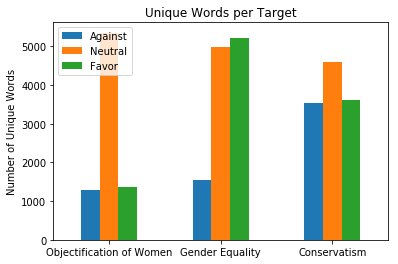

In [28]:
df.plot(kind='bar', title='Unique Words per Target', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(len(targets)), targets)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_training.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Setup

In [29]:
dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='target_testing'
)

In [30]:
dataloader = DataLoader(dataset)

# Preparing Vocabularies

In [31]:
vocabularies = {
    user_id: {
        word
        for _, (tweet, _, idx) in enumerate(dataloader)
        for word in tokenizer.tokenize(tweet[0])
        if idx == user_id
    }
    for user_id in profile_ids
}

In [32]:
intersection_vocabulary_lengths = {
    user_id: {
        target: {
            label: len(
                vocabularies[user_id].intersection(unique_target_vocabularies[target][label])
            )
            for label in labels
        }
        for target in targets
    }
    for user_id in profile_ids
}

In [33]:
df_obj = pd.DataFrame.from_dict(
    {
        user_id: intersection_vocabulary_lengths[user_id]['Objectification of Women']
        for user_id in profile_ids
    },
    orient='index'
)

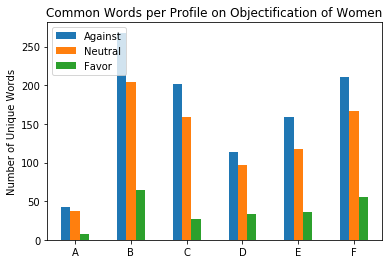

In [34]:
df_obj.plot(kind='bar', title='Common Words per Profile on Objectification of Women', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(len(users)), users)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_obj.eps', 'wb') as f:
    plt.savefig(f, format='eps')

In [35]:
df_gen = pd.DataFrame.from_dict(
    {
        user_id: intersection_vocabulary_lengths[user_id]['Gender Equality']
        for user_id in profile_ids
    },
    orient='index'
)

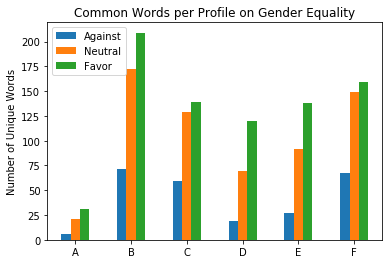

In [36]:
df_gen.plot(kind='bar', title='Common Words per Profile on Gender Equality', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(len(users)), users)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_gen.eps', 'wb') as f:
    plt.savefig(f, format='eps')

In [37]:
df_con = pd.DataFrame.from_dict(
    {
        user_id: intersection_vocabulary_lengths[user_id]['Conservatism']
        for user_id in profile_ids
    },
    orient='index'
)

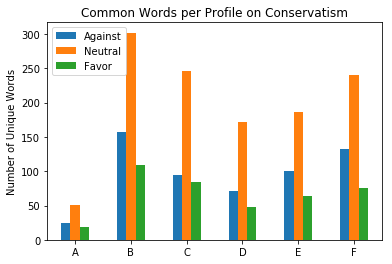

In [38]:
df_con.plot(kind='bar', title='Common Words per Profile on Conservatism', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(len(users)), users)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_con.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Determine Top 10 Words per Profile and Target

In [39]:
vocabularies_counters = {
    user_id: {
        target: Counter(
            word
            for _, (tweet, _target, idx) in enumerate(dataloader)
            for word in tokenizer.tokenize(tweet[0])
            if idx == user_id 
            and targets_mapper[int(_target)] == target
            and not word in stopwords_en 
            and not word in string.punctuation
        )
        for target in targets
    }
    for user_id in profile_ids
}

In [40]:
vocabularies_obj_df = pd.DataFrame.from_dict(
    {
        user_id: [
            (word, count)
            for word, count in vocabularies_counters[user_id]['Objectification of Women'].most_common(10)
        ]
        for user_id in profile_ids
    }
)

In [41]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_obj_profiles.tex', 'w') as f:
    vocabularies_obj_df.to_latex(f)

In [42]:
vocabularies_gen_df = pd.DataFrame.from_dict(
    {
        user_id: [
            (word, count)
            for word, count in vocabularies_counters[user_id]['Gender Equality'].most_common(10)
        ]
        for user_id in profile_ids
    }
)

In [43]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_gen_profiles.tex', 'w') as f:
    vocabularies_gen_df.to_latex(f)

In [44]:
vocabularies_con_df = pd.DataFrame.from_dict(
    {
        user_id: [
            (word, count)
            for word, count in vocabularies_counters[user_id]['Conservatism'].most_common(10)
        ]
        for user_id in profile_ids
    }
)

In [45]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_con_profiles.tex', 'w') as f:
    vocabularies_con_df.to_latex(f)